# AWS Data Governance and Security Workshop

This workshop guides you through implementing enterprise-grade security for your data lake using AWS Lake Formation, IAM, and related services. By the end of this workshop, you'll have a secure data environment with:

- A secure data lake with Lake Formation governance
- Column-level security with persona-based access patterns
- LF-Tags for scalable governance
- Comprehensive audit logging and monitoring

## Prerequisites

- AWS account with appropriate permissions
- Knowledge of basic AWS services (S3, IAM, Glue)
- Python with boto3 installed
- AWS CLI configured with admin access

Let's begin by importing the required libraries and setting up our AWS clients.

In [1]:
import boto3
import json
import time
from botocore.exceptions import ClientError
import pandas as pd
import matplotlib.pyplot as plt
import pprint

# Initialize AWS clients
session = boto3.session.Session()
region = session.region_name
account_id = boto3.client('sts').get_caller_identity()['Account']

lakeformation = boto3.client('lakeformation')
glue = boto3.client('glue')
iam = boto3.client('iam')
s3 = boto3.client('s3')
cloudtrail = boto3.client('cloudtrail')
cloudwatch = boto3.client('cloudwatch')
logs = boto3.client('logs')

print(f"Using AWS region: {region}")
print(f"Using AWS account: {account_id}")

/Users/sanjij/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Using AWS region: ap-south-1
Using AWS account: 359373501475


## Module 1: Setting Up the Data Lake Foundation

In this module, we'll create a secure foundation for our data lake by:
1. Creating an S3 bucket with encryption and versioning enabled
2. Registering the bucket with Lake Formation
3. Creating domain-specific databases in the Glue Data Catalog

### Step 1: Create a secure S3 bucket for the data lake

In [2]:
def create_data_lake_bucket():
    """Create an encrypted S3 bucket for the data lake"""
    bucket_name = f'enterprise-data-lake-{account_id}'
    
    try:
        # Create the bucket
        s3.create_bucket(
            Bucket=bucket_name,
            CreateBucketConfiguration={'LocationConstraint': region}
        )
        
        # Enable encryption
        s3.put_bucket_encryption(
            Bucket=bucket_name,
            ServerSideEncryptionConfiguration={
                'Rules': [
                    {
                        'ApplyServerSideEncryptionByDefault': {
                            'SSEAlgorithm': 'AES256'
                        },
                        'BucketKeyEnabled': True
                    }
                ]
            }
        )
        
        # Enable versioning
        s3.put_bucket_versioning(
            Bucket=bucket_name,
            VersioningConfiguration={'Status': 'Enabled'}
        )
        
        print(f"Created data lake bucket: {bucket_name}")
        return bucket_name
    except ClientError as e:
        if e.response['Error']['Code'] == 'BucketAlreadyOwnedByYou':
            print(f"Bucket {bucket_name} already exists")
            return bucket_name
        else:
            raise

bucket_name = create_data_lake_bucket()
print(f"Data lake bucket: {bucket_name}")

Created data lake bucket: enterprise-data-lake-359373501475
Data lake bucket: enterprise-data-lake-359373501475


### Step 2: Register the S3 bucket with Lake Formation

For Lake Formation to manage permissions on the data lake, we need to register the S3 bucket as a data lake location.

In [3]:
def register_data_lake_location(bucket_name):
    """Register the S3 bucket with Lake Formation"""
    try:
        # Create IAM role for Lake Formation
        role_name = 'LakeFormationServiceRole'
        assume_role_policy = {
            "Version": "2012-10-17",
            "Statement": [
                {
                    "Effect": "Allow",
                    "Principal": {"Service": "lakeformation.amazonaws.com"},
                    "Action": "sts:AssumeRole"
                }
            ]
        }
        
        try:
            iam.create_role(
                RoleName=role_name,
                AssumeRolePolicyDocument=json.dumps(assume_role_policy)
            )
            
            # Attach required policies
            iam.attach_role_policy(
                RoleName=role_name,
                PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess'
            )
            
            # Wait for IAM role to propagate
            print("Waiting for IAM role to propagate...")
            time.sleep(10)
            
        except ClientError as e:
            if e.response['Error']['Code'] == 'EntityAlreadyExists':
                print(f"Role {role_name} already exists")
            else:
                raise
        
        # Get role ARN
        role_arn = iam.get_role(RoleName=role_name)['Role']['Arn']
        
        # Register data lake location
        lakeformation.register_resource(
            ResourceArn=f"arn:aws:s3:::{bucket_name}",
            UseServiceLinkedRole=False,
            RoleArn=role_arn
        )
        
        print(f"Registered data lake location: s3://{bucket_name}")
        return True
    except ClientError as e:
        print(f"Error registering data lake location: {e}")
        raise

register_data_lake_location(bucket_name)

Waiting for IAM role to propagate...
Registered data lake location: s3://enterprise-data-lake-359373501475


True

### Step 3: Create domain-specific databases

Now, let's create databases in the Glue Data Catalog to organize our data by domain.

In [4]:
def create_domain_databases():
    """Create databases for different domains"""
    databases = ['customer_domain', 'sales_domain', 'product_domain']
    
    for db_name in databases:
        try:
            glue.create_database(
                DatabaseInput={
                    'Name': db_name,
                    'Description': f'Data for {db_name.split("_")[0]} domain',
                    'Parameters': {
                        'domain': db_name.split('_')[0],
                        'created_by': 'data_governance_workshop'
                    }
                }
            )
            print(f"Created database: {db_name}")
        except ClientError as e:
            if e.response['Error']['Code'] == 'AlreadyExistsException':
                print(f"Database {db_name} already exists")
            else:
                raise

create_domain_databases()

# List the created databases to verify
response = glue.get_databases()
databases = [db['Name'] for db in response['DatabaseList']]
print("\nAvailable databases:")
for db in databases:
    print(f"- {db}")

Created database: customer_domain
Created database: sales_domain
Created database: product_domain

Available databases:
- customer_domain
- default
- demo1
- demo_database_creation
- executionstatus
- ny_taxi_ver1
- nytaxi_db
- osm_data
- osm_database
- product_domain
- retail_etl
- sales_domain
- tata_power_interval_data


## Module 2: Creating Sample Tables with Sensitive Data

In this module, we'll create sample tables that include sensitive data. We'll set up:
1. A customer_profiles table with PII (personally identifiable information)
2. A transactions table with sales data

These tables will be used to demonstrate security controls in the following modules.

In [9]:
def create_sensitive_tables(bucket_name):
    """Create tables containing various types of sensitive data"""
    
    # Customer profiles table with PII
    try:
        glue.create_table(
            DatabaseName='customer_domain',
            TableInput={
                'Name': 'customer_profiles',
                'StorageDescriptor': {
                    'Columns': [
                        {'Name': 'customer_id', 'Type': 'string'},
                        {'Name': 'name', 'Type': 'string'},
                        {'Name': 'email', 'Type': 'string'},
                        {'Name': 'phone', 'Type': 'string'},
                        {'Name': 'address', 'Type': 'string'},
                        {'Name': 'social_security_number', 'Type': 'string'},
                        {'Name': 'credit_score', 'Type': 'int'},
                        {'Name': 'birth_date', 'Type': 'date'},
                        {'Name': 'signup_date', 'Type': 'date'},
                        {'Name': 'customer_segment', 'Type': 'string'}
                    ],
                    'Location': f's3://{bucket_name}/customer_domain/customer_profiles/',
                    'InputFormat': 'org.apache.hadoop.mapred.TextInputFormat',
                    'OutputFormat': 'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat',
                    'SerdeInfo': {
                        'SerializationLibrary': 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe',
                        'Parameters': {'field.delim': ','}
                    }
                },
                'TableType': 'EXTERNAL_TABLE',
                'Parameters': {
                    'classification': 'csv',
                    'contains_pii': 'true',
                    'domain': 'customer'
                }
            }
        )
        print("Created customer_profiles table with sensitive data")
    except ClientError as e:
        if e.response['Error']['Code'] == 'AlreadyExistsException':
            print("Table customer_profiles already exists")
        else:
            raise
    
    # Sales transactions table
    try:
        glue.create_table(
            DatabaseName='sales_domain',
            TableInput={
                'Name': 'transactions',
                'StorageDescriptor': {
                    'Columns': [
                        {'Name': 'transaction_id', 'Type': 'string'},
                        {'Name': 'customer_id', 'Type': 'string'},
                        {'Name': 'transaction_date', 'Type': 'timestamp'},
                        {'Name': 'amount', 'Type': 'decimal(10,2)'},
                        {'Name': 'payment_method', 'Type': 'string'},
                        {'Name': 'product_id', 'Type': 'string'},
                        {'Name': 'store_id', 'Type': 'string'}
                    ],
                    'Location': f's3://{bucket_name}/sales_domain/transactions/',
                    'InputFormat': 'org.apache.hadoop.mapred.TextInputFormat',
                    'OutputFormat': 'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat',
                    'SerdeInfo': {
                        'SerializationLibrary': 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe',
                        'Parameters': {'field.delim': ','}
                    }
                },
                'TableType': 'EXTERNAL_TABLE',
                'Parameters': {
                    'classification': 'csv',
                    'contains_pii': 'false',
                    'domain': 'sales'
                }
            }
        )
        print("Created transactions table")
    except ClientError as e:
        if e.response['Error']['Code'] == 'AlreadyExistsException':
            print("Table transactions already exists")
        else:
            raise

create_sensitive_tables(bucket_name)

Created customer_profiles table with sensitive data
Created transactions table


### Generate sample data for the tables

Let's create some sample data for our tables and upload it to S3. This data will allow us to test our security controls.

In [10]:
import pandas as pd
import numpy as np
import io
from datetime import datetime, timedelta
import random

# Create sample customer profiles data
def generate_customer_data(num_customers=100):
    np.random.seed(42)  # For reproducibility
    
    domains = ['gmail.com', 'yahoo.com', 'hotmail.com', 'outlook.com', 'company.com']
    segments = ['Premium', 'Standard', 'Basic', 'Enterprise', 'Trial']
    
    data = {
        'customer_id': [f'C{str(i).zfill(6)}' for i in range(1, num_customers+1)],
        'name': [f'Customer {i}' for i in range(1, num_customers+1)],
        'email': [f'customer{i}@{random.choice(domains)}' for i in range(1, num_customers+1)],
        'phone': [f'555-{str(random.randint(100, 999))}-{str(random.randint(1000, 9999))}' for _ in range(num_customers)],
        'address': [f'{random.randint(100, 9999)} Main St, City {i}, State' for i in range(1, num_customers+1)],
        'social_security_number': [f'{random.randint(100, 999)}-{random.randint(10, 99)}-{random.randint(1000, 9999)}' for _ in range(num_customers)],
        'credit_score': np.random.randint(300, 850, num_customers),
        'birth_date': [(datetime.now() - timedelta(days=random.randint(365*18, 365*80))).strftime('%Y-%m-%d') for _ in range(num_customers)],
        'signup_date': [(datetime.now() - timedelta(days=random.randint(1, 1000))).strftime('%Y-%m-%d') for _ in range(num_customers)],
        'customer_segment': [random.choice(segments) for _ in range(num_customers)]
    }
    
    return pd.DataFrame(data)

# Create sample transaction data
def generate_transaction_data(num_transactions=500, customer_ids=None):
    np.random.seed(42)  # For reproducibility
    
    if customer_ids is None:
        customer_ids = [f'C{str(i).zfill(6)}' for i in range(1, 101)]
    
    payment_methods = ['Credit Card', 'Debit Card', 'PayPal', 'Bank Transfer', 'Cash']
    product_ids = [f'P{str(i).zfill(4)}' for i in range(1, 51)]
    store_ids = [f'S{str(i).zfill(3)}' for i in range(1, 11)]
    
    data = {
        'transaction_id': [f'T{str(i).zfill(8)}' for i in range(1, num_transactions+1)],
        'customer_id': [random.choice(customer_ids) for _ in range(num_transactions)],
        'transaction_date': [(datetime.now() - timedelta(days=random.randint(0, 365))).strftime('%Y-%m-%d %H:%M:%S') for _ in range(num_transactions)],
        'amount': np.round(np.random.uniform(10, 1000, num_transactions), 2),
        'payment_method': [random.choice(payment_methods) for _ in range(num_transactions)],
        'product_id': [random.choice(product_ids) for _ in range(num_transactions)],
        'store_id': [random.choice(store_ids) for _ in range(num_transactions)]
    }
    
    return pd.DataFrame(data)

# Generate sample data
customer_df = generate_customer_data(100)
transaction_df = generate_transaction_data(500, customer_df['customer_id'].tolist())

# Display sample data
print("Sample customer data:")
display(customer_df.head(3))

print("\nSample transaction data:")
display(transaction_df.head(3))

Sample customer data:


,customer_id,name,email,phone,address,social_security_number,credit_score,birth_date,signup_date,customer_segment
0,C000001,Customer 1,customer1@gmail.com,555-193-9902,"727 Main St, City 1, State",880-97-5511,402,1965-09-16,2023-12-08,Enterprise
1,C000002,Customer 2,customer2@yahoo.com,555-509-5229,"4618 Main St, City 2, State",414-32-2429,735,1974-10-10,2025-01-27,Standard
2,C000003,Customer 3,customer3@hotmail.com,555-931-6937,"1756 Main St, City 3, State",837-89-9976,570,2000-04-02,2022-09-13,Enterprise



Sample transaction data:


,transaction_id,customer_id,transaction_date,amount,payment_method,product_id,store_id
0,T00000001,C000039,2024-11-18 13:58:19,380.79,PayPal,P0006,S006
1,T00000002,C000068,2024-07-09 13:58:19,951.21,Debit Card,P0021,S006
2,T00000003,C000060,2024-10-18 13:58:19,734.67,Debit Card,P0015,S002


In [11]:
# Upload the sample data to S3
def upload_dataframe_to_s3(df, bucket, key):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index=False)
    s3.put_object(Bucket=bucket, Key=key, Body=csv_buffer.getvalue())
    print(f"Uploaded data to s3://{bucket}/{key}")

# Upload customer data
upload_dataframe_to_s3(customer_df, bucket_name, 'customer_domain/customer_profiles/data.csv')

# Upload transaction data
upload_dataframe_to_s3(transaction_df, bucket_name, 'sales_domain/transactions/data.csv')

Uploaded data to s3://enterprise-data-lake-359373501475/customer_domain/customer_profiles/data.csv
Uploaded data to s3://enterprise-data-lake-359373501475/sales_domain/transactions/data.csv


## Module 3: Implementing Persona-Based Security

In this module, we'll create IAM roles for different user personas and apply appropriate Lake Formation permissions for each role.

We'll create the following personas:
- **Data Analyst**: Basic access to business data
- **Data Scientist**: Broader access but restricted from the most sensitive fields
- **Marketing Analyst**: Access focused on marketing-relevant fields
- **Data Steward**: Metadata management permissions

### Step 1: Create IAM roles for each persona

In [12]:
def create_persona_roles():
    """Create IAM roles for different personas"""
    personas = {
        'DataAnalyst': {
            'description': 'Role for data analysts with limited access',
            'policies': ['AmazonAthenaFullAccess']
        },
        'DataScientist': {
            'description': 'Role for data scientists with broader access',
            'policies': ['AmazonAthenaFullAccess', 'AmazonSageMakerFullAccess']
        },
        'MarketingAnalyst': {
            'description': 'Role for marketing team analysts',
            'policies': ['AmazonAthenaFullAccess']
        },
        'DataSteward': {
            'description': 'Role for data governance and metadata management',
            'policies': ['AWSGlueConsoleFullAccess']
        }
    }
    
    created_roles = {}
    
    for role_name, config in personas.items():
        try:
            # Create role
            assume_role_policy = {
                "Version": "2012-10-17",
                "Statement": [
                    {
                        "Effect": "Allow",
                        "Principal": {"Service": "glue.amazonaws.com"},
                        "Action": "sts:AssumeRole"
                    }
                ]
            }
            
            response = iam.create_role(
                RoleName=role_name,
                AssumeRolePolicyDocument=json.dumps(assume_role_policy),
                Description=config['description']
            )
            
            role_arn = response['Role']['Arn']
            created_roles[role_name] = role_arn
            
            # Attach managed policies
            for policy in config['policies']:
                iam.attach_role_policy(
                    RoleName=role_name,
                    PolicyArn=f'arn:aws:iam::aws:policy/{policy}'
                )
            
            print(f"Created IAM role: {role_name} ({role_arn})")
        except ClientError as e:
            if e.response['Error']['Code'] == 'EntityAlreadyExists':
                print(f"Role {role_name} already exists")
                role_arn = iam.get_role(RoleName=role_name)['Role']['Arn']
                created_roles[role_name] = role_arn
            else:
                raise
    
    return created_roles

persona_roles = create_persona_roles()
print("\nCreated persona roles:")
for role, arn in persona_roles.items():
    print(f"- {role}: {arn}")

Created IAM role: DataAnalyst (arn:aws:iam::359373501475:role/DataAnalyst)
Created IAM role: DataScientist (arn:aws:iam::359373501475:role/DataScientist)
Created IAM role: MarketingAnalyst (arn:aws:iam::359373501475:role/MarketingAnalyst)
Created IAM role: DataSteward (arn:aws:iam::359373501475:role/DataSteward)

Created persona roles:
- DataAnalyst: arn:aws:iam::359373501475:role/DataAnalyst
- DataScientist: arn:aws:iam::359373501475:role/DataScientist
- MarketingAnalyst: arn:aws:iam::359373501475:role/MarketingAnalyst
- DataSteward: arn:aws:iam::359373501475:role/DataSteward


### Step 2: Implement column-level security using Lake Formation

Now let's apply column-level security to restrict access to sensitive fields based on each persona's legitimate needs.

In [13]:
def implement_column_level_security(roles):
    """Implement column-level security with Lake Formation"""
    try:
        # Grant database permissions
        for role_name, role_arn in roles.items():
            lakeformation.grant_permissions(
                Principal={'DataLakePrincipalIdentifier': role_arn},
                Resource={'Database': {'Name': 'customer_domain'}},
                Permissions=['DESCRIBE']
            )
            
            lakeformation.grant_permissions(
                Principal={'DataLakePrincipalIdentifier': role_arn},
                Resource={'Database': {'Name': 'sales_domain'}},
                Permissions=['DESCRIBE']
            )
        print("Granted database-level permissions to all roles")
        
        # Data Analyst - Limited view
        lakeformation.grant_permissions(
            Principal={'DataLakePrincipalIdentifier': roles['DataAnalyst']},
            Resource={
                'Table': {
                    'DatabaseName': 'customer_domain',
                    'Name': 'customer_profiles',
                    'ColumnWildcard': {
                        'ExcludedColumnNames': [
                            'social_security_number', 
                            'credit_score', 
                            'phone', 
                            'address',
                            'birth_date'
                        ]
                    }
                }
            },
            Permissions=['SELECT']
        )
        
        # Grant access to sales data
        lakeformation.grant_permissions(
            Principal={'DataLakePrincipalIdentifier': roles['DataAnalyst']},
            Resource={
                'Table': {
                    'DatabaseName': 'sales_domain',
                    'Name': 'transactions'
                }
            },
            Permissions=['SELECT']
        )
        
        print("Granted limited column access to DataAnalyst")
        
        # Data Scientist - More columns but still restricted
        lakeformation.grant_permissions(
            Principal={'DataLakePrincipalIdentifier': roles['DataScientist']},
            Resource={
                'Table': {
                    'DatabaseName': 'customer_domain',
                    'Name': 'customer_profiles',
                    'ColumnWildcard': {
                        'ExcludedColumnNames': ['social_security_number']
                    }
                }
            },
            Permissions=['SELECT']
        )
        
        # Grant full access to sales data
        lakeformation.grant_permissions(
            Principal={'DataLakePrincipalIdentifier': roles['DataScientist']},
            Resource={
                'Table': {
                    'DatabaseName': 'sales_domain',
                    'Name': 'transactions'
                }
            },
            Permissions=['SELECT']
        )
        
        print("Granted broader column access to DataScientist")
        
        # Marketing Analyst - Marketing focused view
        lakeformation.grant_permissions(
            Principal={'DataLakePrincipalIdentifier': roles['MarketingAnalyst']},
            Resource={
                'Table': {
                    'DatabaseName': 'customer_domain',
                    'Name': 'customer_profiles',
                    'ColumnNames': [
                        'customer_id', 
                        'customer_segment', 
                        'signup_date',
                        'email'
                    ]
                }
            },
            Permissions=['SELECT']
        )
        
        # Limited sales data for marketing
        lakeformation.grant_permissions(
            Principal={'DataLakePrincipalIdentifier': roles['MarketingAnalyst']},
            Resource={
                'Table': {
                    'DatabaseName': 'sales_domain',
                    'Name': 'transactions',
                    'ColumnNames': [
                        'customer_id', 
                        'transaction_date', 
                        'amount', 
                        'product_id'
                    ]
                }
            },
            Permissions=['SELECT']
        )
        
        print("Granted marketing-focused access to MarketingAnalyst")
        
        # Data Steward - Full metadata access
        lakeformation.grant_permissions(
            Principal={'DataLakePrincipalIdentifier': roles['DataSteward']},
            Resource={'Catalog': {}},
            Permissions=['CREATE_DATABASE']
        )
        
        # Database level permissions
        for db in ['customer_domain', 'sales_domain', 'product_domain']:
            lakeformation.grant_permissions(
                Principal={'DataLakePrincipalIdentifier': roles['DataSteward']},
                Resource={'Database': {'Name': db}},
                Permissions=['ALTER', 'CREATE_TABLE', 'DROP', 'DESCRIBE']
            )
        
        print("Granted metadata management access to DataSteward")
        
    except ClientError as e:
        print(f"Error implementing column security: {e}")
        raise

# Implement column-level security
implement_column_level_security(persona_roles)

Error implementing column security: An error occurred (InvalidInputException) when calling the GrantPermissions operation: Invalid principal, arn: arn:aws:iam::359373501475:role/DataSteward


InvalidInputException: An error occurred (InvalidInputException) when calling the GrantPermissions operation: Invalid principal, arn: arn:aws:iam::359373501475:role/DataSteward

### Step 3: Verify Lake Formation permissions

Let's check the permissions we've granted to confirm they're set up correctly.

In [15]:
def check_lake_formation_permissions():
    """Check Lake Formation permissions for a resource"""
    
    # Check permissions for customer_profiles table
    print("\nPermissions for customer_profiles table:")
    for role_name, role_arn in persona_roles.items():
        try:
            # Specify both Principal and Resource
            response = lakeformation.list_permissions(
                Principal={'DataLakePrincipalIdentifier': role_arn},
                ResourceType='TABLE',
                Resource={
                    'Table': {
                        'DatabaseName': 'customer_domain',
                        'Name': 'customer_profiles'
                    }
                }
            )
            
            # Filter for customer_profiles table
            permissions = [p for p in response.get('PrincipalResourcePermissions', []) 
                         if p.get('Resource', {}).get('Table', {}).get('Name') == 'customer_profiles']
            
            print(f"\nRole: {role_name}")
            if not permissions:
                print("  No direct table permissions found")
            
            for perm in permissions:
                resource = perm.get('Resource', {}).get('Table', {})
                print(f"  Permissions: {perm.get('Permissions', [])}")
                
                # Show column restrictions if any
                if 'ColumnWildcard' in resource:
                    excluded = resource['ColumnWildcard'].get('ExcludedColumnNames', [])
                    print(f"  Excluded columns: {excluded}")
                elif 'ColumnNames' in resource:
                    columns = resource['ColumnNames']
                    print(f"  Specific columns: {columns}")
                else:
                    print("  All columns")
                    
        except ClientError as e:
            print(f"Error checking permissions for {role_name}: {e}")

check_lake_formation_permissions()


Permissions for customer_profiles table:

Role: DataAnalyst
  Permissions: ['ALL']
  All columns

Role: DataScientist
  Permissions: ['ALL']
  All columns

Role: MarketingAnalyst
  Permissions: ['ALL']
  All columns

Role: DataSteward
  Permissions: ['ALL']
  All columns


## Module 4: Setting Up LF-Tags for Scalable Governance

LF-Tags provide a scalable way to manage permissions based on data attributes rather than individual resources. In this module, we'll:
1. Create LF-Tags for data sensitivity and domain
2. Assign tags to databases and columns
3. Grant permissions based on tag expressions

### Step 1: Create LF-Tags

In [17]:
def create_lf_tags():
    """Create LF-Tags for data governance"""
    # Define tags and their allowed values
    tags = {
        'Sensitivity': ['Public', 'Internal', 'Confidential', 'Restricted'],
        'Domain': ['Customer', 'Sales', 'Product', 'Finance'],
        'DataType': ['PII', 'Transactional', 'Reference', 'Analytical']
    }
    
    created_tags = {}
    
    for tag_key, tag_values in tags.items():
        try:
            lakeformation.create_lf_tag(
                TagKey=tag_key,
                TagValues=tag_values
            )
            created_tags[tag_key] = tag_values
            print(f"Created LF-Tag: {tag_key} with values {tag_values}")
        except ClientError as e:
            if e.response['Error']['Code'] == 'AlreadyExistsException':
                print(f"LF-Tag {tag_key} already exists")
                created_tags[tag_key] = tag_values
            else:
                raise
    
    return created_tags

lf_tags = create_lf_tags()

# List existing LF-Tags to verify
try:
    response = lakeformation.list_lf_tags()
    print("\nExisting LF-Tags:")
    for tag in response.get('LFTags', []):
        print(f"- {tag['TagKey']}: {tag['TagValues']}")
except ClientError as e:
    print(f"Error listing LF-Tags: {e}")

Created LF-Tag: Sensitivity with values ['Public', 'Internal', 'Confidential', 'Restricted']
Created LF-Tag: Domain with values ['Customer', 'Sales', 'Product', 'Finance']
Created LF-Tag: DataType with values ['PII', 'Transactional', 'Reference', 'Analytical']

Existing LF-Tags:
- DataType: ['PII', 'Analytical', 'Reference', 'Transactional']
- Domain: ['Sales', 'Customer', 'Finance', 'Product']
- Sensitivity: ['Restricted', 'Internal', 'Confidential', 'Public']


### Step 2: Assign LF-Tags to databases and columns

In [18]:
def assign_lf_tags():
    """Assign LF-Tags to databases and columns"""
    # Assign tags to databases
    db_tags = {
        'customer_domain': {
            'Domain': ['Customer'],
            'Sensitivity': ['Confidential']
        },
        'sales_domain': {
            'Domain': ['Sales'],
            'Sensitivity': ['Internal']
        },
        'product_domain': {
            'Domain': ['Product'],
            'Sensitivity': ['Public']
        }
    }
    
    for db_name, tags in db_tags.items():
        for tag_key, tag_values in tags.items():
            try:
                lakeformation.add_lf_tags_to_resource(
                    Resource={'Database': {'Name': db_name}},
                    LFTags=[
                        {'TagKey': tag_key, 'TagValues': tag_values}
                    ]
                )
                print(f"Assigned {tag_key}={tag_values} to database {db_name}")
            except ClientError as e:
                print(f"Error assigning tag to database {db_name}: {e}")
    
    # Define column-level sensitivity tags for customer_profiles
    column_tags = [
        # Public columns
        {'Column': 'customer_id', 'TagKey': 'Sensitivity', 'TagValues': ['Public']},
        {'Column': 'customer_segment', 'TagKey': 'Sensitivity', 'TagValues': ['Public']},
        {'Column': 'signup_date', 'TagKey': 'Sensitivity', 'TagValues': ['Public']},
        
        # Internal columns
        {'Column': 'name', 'TagKey': 'Sensitivity', 'TagValues': ['Internal']},
        {'Column': 'email', 'TagKey': 'Sensitivity', 'TagValues': ['Internal']},
        
        # Confidential columns
        {'Column': 'phone', 'TagKey': 'Sensitivity', 'TagValues': ['Confidential']},
        {'Column': 'address', 'TagKey': 'Sensitivity', 'TagValues': ['Confidential']},
        {'Column': 'credit_score', 'TagKey': 'Sensitivity', 'TagValues': ['Confidential']},
        {'Column': 'birth_date', 'TagKey': 'Sensitivity', 'TagValues': ['Confidential']},
        
        # Restricted columns
        {'Column': 'social_security_number', 'TagKey': 'Sensitivity', 'TagValues': ['Restricted']},
        
        # PII data type
        {'Column': 'name', 'TagKey': 'DataType', 'TagValues': ['PII']},
        {'Column': 'email', 'TagKey': 'DataType', 'TagValues': ['PII']},
        {'Column': 'phone', 'TagKey': 'DataType', 'TagValues': ['PII']},
        {'Column': 'address', 'TagKey': 'DataType', 'TagValues': ['PII']},
        {'Column': 'social_security_number', 'TagKey': 'DataType', 'TagValues': ['PII']},
        {'Column': 'birth_date', 'TagKey': 'DataType', 'TagValues': ['PII']}
    ]
    
    # Assign tags to columns
    for tag_info in column_tags:
        try:
            lakeformation.add_lf_tags_to_resource(
                Resource={
                    'TableWithColumns': {
                        'DatabaseName': 'customer_domain',
                        'Name': 'customer_profiles',
                        'ColumnNames': [tag_info['Column']]
                    }
                },
                LFTags=[
                    {'TagKey': tag_info['TagKey'], 'TagValues': tag_info['TagValues']}
                ]
            )
            print(f"Assigned {tag_info['TagKey']}={tag_info['TagValues'][0]} to column {tag_info['Column']}")
        except ClientError as e:
            print(f"Error assigning tag to column: {e}")

assign_lf_tags()

Assigned Domain=['Customer'] to database customer_domain
Assigned Sensitivity=['Confidential'] to database customer_domain
Assigned Domain=['Sales'] to database sales_domain
Assigned Sensitivity=['Internal'] to database sales_domain
Assigned Domain=['Product'] to database product_domain
Assigned Sensitivity=['Public'] to database product_domain
Assigned Sensitivity=Public to column customer_id
Assigned Sensitivity=Public to column customer_segment
Assigned Sensitivity=Public to column signup_date
Assigned Sensitivity=Internal to column name
Assigned Sensitivity=Internal to column email
Assigned Sensitivity=Confidential to column phone
Assigned Sensitivity=Confidential to column address
Assigned Sensitivity=Confidential to column credit_score
Assigned Sensitivity=Confidential to column birth_date
Assigned Sensitivity=Restricted to column social_security_number
Assigned DataType=PII to column name
Assigned DataType=PII to column email
Assigned DataType=PII to column phone
Assigned DataTy

### Step 3: Grant permissions based on LF-Tags

Now we'll grant permissions based on tag expressions, which provides a scalable way to manage access as new tables and columns are added.

In [21]:
def grant_tag_based_permissions():
    """Grant permissions based on LF-Tag expressions"""
    
    # Data Analyst gets Public and Internal data
    try:
        lakeformation.grant_permissions(
            Principal={'DataLakePrincipalIdentifier': persona_roles['DataAnalyst']},
            Resource={'LFTagPolicy': {
                'ResourceType': 'TABLE',
                'Expression': [
                    {
                        'TagKey': 'Sensitivity',
                        'TagValues': ['Public', 'Internal']
                    }
                ]
            }},
            Permissions=['SELECT']
        )
        print("Granted tag-based permissions to DataAnalyst (Public, Internal)")
    except ClientError as e:
        print(f"Error granting tag-based permissions to DataAnalyst: {e}")
    
    # Data Scientist gets Public, Internal, and Confidential data
    try:
        lakeformation.grant_permissions(
            Principal={'DataLakePrincipalIdentifier': persona_roles['DataScientist']},
            Resource={'LFTagPolicy': {
                'ResourceType': 'TABLE',
                'Expression': [
                    {
                        'TagKey': 'Sensitivity',
                        'TagValues': ['Public', 'Internal', 'Confidential']
                    }
                ]
            }},
            Permissions=['SELECT']
        )
        print("Granted tag-based permissions to DataScientist (Public, Internal, Confidential)")
    except ClientError as e:
        print(f"Error granting tag-based permissions to DataScientist: {e}")
    
    # Marketing Analyst gets Public data and PII data needed for marketing
    try:
        # First grant access to Public data
        lakeformation.grant_permissions(
            Principal={'DataLakePrincipalIdentifier': persona_roles['MarketingAnalyst']},
            Resource={'LFTagPolicy': {
                'ResourceType': 'TABLE',
                'Expression': [
                    {
                        'TagKey': 'Sensitivity',
                        'TagValues': ['Public']
                    }
                ]
            }},
            Permissions=['SELECT']
        )
        
        # Then grant access to email for marketing purposes
        lakeformation.grant_permissions(
            Principal={'DataLakePrincipalIdentifier': persona_roles['MarketingAnalyst']},
            Resource={
                'TableWithColumns': {
                    'DatabaseName': 'customer_domain',
                    'Name': 'customer_profiles',
                    'ColumnNames': ['email']
                }
            },
            Permissions=['SELECT']
        )
        
        print("Granted tag-based permissions to MarketingAnalyst (Public + email)")
    except ClientError as e:
        print(f"Error granting tag-based permissions to MarketingAnalyst: {e}")
    
    # Data Steward gets access to all data for governance
    try:
        lakeformation.grant_permissions(
            Principal={'DataLakePrincipalIdentifier': persona_roles['DataSteward']},
            Resource={'LFTagPolicy': {
                'ResourceType': 'TABLE',
                'Expression': [
                    {
                        'TagKey': 'Sensitivity',
                        'TagValues': ['Public', 'Internal', 'Confidential', 'Restricted']
                    }
                ]
            }},
            Permissions=['SELECT', 'DESCRIBE', 'ALTER']
        )
        print("Granted tag-based permissions to DataSteward (All sensitivity levels)")
    except ClientError as e:
        print(f"Error granting tag-based permissions to DataSteward: {e}")

grant_tag_based_permissions()

Granted tag-based permissions to DataAnalyst (Public, Internal)
Granted tag-based permissions to DataScientist (Public, Internal, Confidential)
Granted tag-based permissions to MarketingAnalyst (Public + email)
Granted tag-based permissions to DataSteward (All sensitivity levels)


## Module 5: Setting Up Audit and Monitoring

In this module, we'll set up comprehensive audit logging and monitoring to track data access and detect potential security issues.

We'll configure:
1. CloudTrail for API audit logging
2. CloudWatch for monitoring and alerting
3. Metrics for sensitive data access

### Step 1: Create an S3 bucket for audit logs

In [22]:
def create_audit_log_bucket():
    """Create an S3 bucket for storing audit logs"""
    audit_bucket_name = f'data-governance-audit-{account_id}'
    
    try:
        # Create the bucket
        s3.create_bucket(
            Bucket=audit_bucket_name,
            CreateBucketConfiguration={'LocationConstraint': region}
        )
        
        # Enable encryption
        s3.put_bucket_encryption(
            Bucket=audit_bucket_name,
            ServerSideEncryptionConfiguration={
                'Rules': [
                    {
                        'ApplyServerSideEncryptionByDefault': {
                            'SSEAlgorithm': 'AES256'
                        },
                        'BucketKeyEnabled': True
                    }
                ]
            }
        )
        
        # Add bucket policy for CloudTrail
        bucket_policy = {
            "Version": "2012-10-17",
            "Statement": [
                {
                    "Sid": "AWSCloudTrailAclCheck",
                    "Effect": "Allow",
                    "Principal": {"Service": "cloudtrail.amazonaws.com"},
                    "Action": "s3:GetBucketAcl",
                    "Resource": f"arn:aws:s3:::{audit_bucket_name}"
                },
                {
                    "Sid": "AWSCloudTrailWrite",
                    "Effect": "Allow",
                    "Principal": {"Service": "cloudtrail.amazonaws.com"},
                    "Action": "s3:PutObject",
                    "Resource": f"arn:aws:s3:::{audit_bucket_name}/AWSLogs/*",
                    "Condition": {
                        "StringEquals": {
                            "s3:x-amz-acl": "bucket-owner-full-control"
                        }
                    }
                }
            ]
        }
        
        s3.put_bucket_policy(
            Bucket=audit_bucket_name,
            Policy=json.dumps(bucket_policy)
        )
        
        print(f"Created audit bucket: {audit_bucket_name}")
        return audit_bucket_name
    except ClientError as e:
        if e.response['Error']['Code'] == 'BucketAlreadyOwnedByYou':
            print(f"Audit bucket {audit_bucket_name} already exists")
            return audit_bucket_name
        else:
            raise

audit_bucket = create_audit_log_bucket()

Created audit bucket: data-governance-audit-359373501475


### Step 2: Configure CloudTrail for data access logging

In [23]:
def setup_cloudtrail(audit_bucket_name):
    """Set up CloudTrail for data access logging"""
    try:
        # Create CloudTrail trail
        cloudtrail.create_trail(
            Name='DataGovernanceAudit',
            S3BucketName=audit_bucket_name,
            IncludeGlobalServiceEvents=True,
            IsMultiRegionTrail=True,
            EnableLogFileValidation=True
        )
        
        # Start logging
        cloudtrail.start_logging(Name='DataGovernanceAudit')
        
        # Add event selectors for S3 data events
        cloudtrail.put_event_selectors(
            TrailName='DataGovernanceAudit',
            EventSelectors=[
                {
                    'ReadWriteType': 'All',
                    'IncludeManagementEvents': True,
                    'DataResources': [
                        {
                            'Type': 'AWS::S3::Object',
                            'Values': [f'arn:aws:s3:::{bucket_name}/']
                        }
                    ]
                }
            ]
        )
        
        print("Created CloudTrail trail for data access audit")
        return True
    except ClientError as e:
        if 'TrailAlreadyExists' in str(e):
            print("CloudTrail trail already exists")
            return True
        else:
            raise

setup_cloudtrail(audit_bucket)

Created CloudTrail trail for data access audit


True

### Step 3: Create CloudWatch Log Group and Metric Filters

Now we'll set up CloudWatch log groups and metric filters to monitor for sensitive data access.

In [24]:
def setup_cloudwatch_monitoring():
    """Set up CloudWatch log groups and metric filters"""
    try:
        # Create CloudWatch Log Group for Lake Formation access logs
        logs.create_log_group(
            logGroupName='/aws/lakeformation/access'
        )
        print("Created CloudWatch Log Group for Lake Formation")
    except ClientError as e:
        if e.response['Error']['Code'] == 'ResourceAlreadyExistsException':
            print("CloudWatch Log Group already exists")
        else:
            raise
    
    # Create metric filter for sensitive data access
    try:
        logs.put_metric_filter(
            logGroupName='/aws/lakeformation/access',
            filterName='RestrictedDataAccess',
            filterPattern='{ $.columns = "*social_security_number*" || $.columns = "*credit_score*" }',
            metricTransformations=[
                {
                    'metricName': 'RestrictedDataAccess',
                    'metricNamespace': 'DataGovernance',
                    'metricValue': '1'
                }
            ]
        )
        print("Created metric filter for restricted data access")
    except ClientError as e:
        print(f"Error creating metric filter: {e}")
    
    # Create CloudWatch alarm for unusual access
    try:
        cloudwatch.put_metric_alarm(
            AlarmName='UnusualRestrictedDataAccess',
            ComparisonOperator='GreaterThanThreshold',
            EvaluationPeriods=1,
            MetricName='RestrictedDataAccess',
            Namespace='DataGovernance',
            Period=300,  # 5 minutes
            Statistic='Sum',
            Threshold=5,
            AlarmDescription='Unusual amount of access to restricted data detected',
            Dimensions=[
                {
                    'Name': 'TableName',
                    'Value': 'customer_profiles'
                },
            ],
            TreatMissingData='notBreaching'
        )
        print("Created CloudWatch alarm for unusual restricted data access")
    except ClientError as e:
        print(f"Error creating CloudWatch alarm: {e}")

setup_cloudwatch_monitoring()

Created CloudWatch Log Group for Lake Formation
Created metric filter for restricted data access
Created CloudWatch alarm for unusual restricted data access


### Step 4: Create a CloudWatch Dashboard for Monitoring

Let's create a dashboard to visualize our security and access metrics.

In [26]:
def create_monitoring_dashboard():
    """Create a CloudWatch dashboard for security monitoring"""
    try:
        dashboard_body = {
            "widgets": [
                {
                    "type": "metric",
                    "x": 0,
                    "y": 0,
                    "width": 12,
                    "height": 6,
                    "properties": {
                        "metrics": [
                            ["DataGovernance", "RestrictedDataAccess"]
                        ],
                        "period": 300,
                        "stat": "Sum",
                        "region": region,
                        "title": "Restricted Data Access"
                    }
                },
                {
                    "type": "log",
                    "x": 0,
                    "y": 6,
                    "width": 24,
                    "height": 6,
                    "properties": {
                        "query": "SOURCE '/aws/lakeformation/access' | fields @timestamp, @message\n| filter @message like /social_security_number/\n| sort @timestamp desc\n| limit 20",
                        "region": region,
                        "title": "Restricted Data Access Logs",
                        "view": "table"
                    }
                },
                {
                    "type": "metric",
                    "x": 12,
                    "y": 0,
                    "width": 12,
                    "height": 6,
                    "properties": {
                        "metrics": [
                            [ "AWS/S3", "AllRequests", "BucketName", bucket_name ],
                            [ ".", "GetRequests", ".", "." ]
                        ],
                        "period": 300,
                        "stat": "Sum",
                        "region": region,
                        "title": "S3 Data Lake Access"
                    }
                }
            ]
        }
        
        cloudwatch.put_dashboard(
            DashboardName='DataGovernance',
            DashboardBody=json.dumps(dashboard_body)
        )
        
        print("Created CloudWatch dashboard for data governance monitoring")
        print(f"Dashboard URL: https://{region}.console.aws.amazon.com/cloudwatch/home?region={region}#dashboards:name=DataGovernance")
        return True
    except ClientError as e:
        print(f"Error creating dashboard: {e}")
        return False

create_monitoring_dashboard()

Created CloudWatch dashboard for data governance monitoring
Dashboard URL: https://ap-south-1.console.aws.amazon.com/cloudwatch/home?region=ap-south-1#dashboards:name=DataGovernance


True

## Module 6: Testing and Verification

Now that we've implemented our security controls, let's test and verify that they're working as expected.

### Step 1: Testing data access with different personas

In a real-world scenario, you would use Athena to query the data with different IAM roles. For the purposes of this workshop, we'll simulate this by checking the permissions directly.

In [27]:
def test_data_access():
    """Simulate and test data access with different personas"""
    
    # Define the columns each persona should be able to access
    expected_access = {
        'DataAnalyst': {
            'customer_profiles': ['customer_id', 'name', 'email', 'customer_segment', 'signup_date'],
            'transactions': ['transaction_id', 'customer_id', 'transaction_date', 'amount', 'payment_method', 'product_id', 'store_id']
        },
        'DataScientist': {
            'customer_profiles': ['customer_id', 'name', 'email', 'phone', 'address', 'credit_score', 'birth_date', 'signup_date', 'customer_segment'],
            'transactions': ['transaction_id', 'customer_id', 'transaction_date', 'amount', 'payment_method', 'product_id', 'store_id']
        },
        'MarketingAnalyst': {
            'customer_profiles': ['customer_id', 'customer_segment', 'signup_date', 'email'],
            'transactions': ['customer_id', 'transaction_date', 'amount', 'product_id']
        }
    }
    
    # Get customer_profiles table columns
    try:
        cp_table = glue.get_table(DatabaseName='customer_domain', Name='customer_profiles')
        cp_cols = [col['Name'] for col in cp_table['Table']['StorageDescriptor']['Columns']]
        
        # Get transactions table columns
        tx_table = glue.get_table(DatabaseName='sales_domain', Name='transactions')
        tx_cols = [col['Name'] for col in tx_table['Table']['StorageDescriptor']['Columns']]
        
        print("\nTesting data access by persona:")
        for persona, tables in expected_access.items():
            print(f"\n{persona}:")
            
            # Check customer_profiles access
            cp_access = tables['customer_profiles']
            cp_forbidden = [col for col in cp_cols if col not in cp_access]
            
            print(f"  customer_profiles table:")
            print(f"    Can access: {cp_access}")
            print(f"    Cannot access: {cp_forbidden}")
            
            # Check transactions access
            tx_access = tables['transactions']
            tx_forbidden = [col for col in tx_cols if col not in tx_access]
            
            print(f"  transactions table:")
            print(f"    Can access: {tx_access}")
            if tx_forbidden:
                print(f"    Cannot access: {tx_forbidden}")
            else:
                print(f"    Has full access")
    
    except ClientError as e:
        print(f"Error testing data access: {e}")

test_data_access()


Testing data access by persona:

DataAnalyst:
  customer_profiles table:
    Can access: ['customer_id', 'name', 'email', 'customer_segment', 'signup_date']
    Cannot access: ['phone', 'address', 'social_security_number', 'credit_score', 'birth_date']
  transactions table:
    Can access: ['transaction_id', 'customer_id', 'transaction_date', 'amount', 'payment_method', 'product_id', 'store_id']
    Has full access

DataScientist:
  customer_profiles table:
    Can access: ['customer_id', 'name', 'email', 'phone', 'address', 'credit_score', 'birth_date', 'signup_date', 'customer_segment']
    Cannot access: ['social_security_number']
  transactions table:
    Can access: ['transaction_id', 'customer_id', 'transaction_date', 'amount', 'payment_method', 'product_id', 'store_id']
    Has full access

MarketingAnalyst:
  customer_profiles table:
    Can access: ['customer_id', 'customer_segment', 'signup_date', 'email']
    Cannot access: ['name', 'phone', 'address', 'social_security_numb

### Step 2: Visualize column-level permissions by table and persona

Let's create a visualization of which personas can access which columns to better understand our security model.


Column-level permission matrix for customer_profiles table:


,customer_id,name,email,phone,address,social_security_number,credit_score,birth_date,signup_date,customer_segment
DataAnalyst,✓,✓,✓,✗,✗,✗,✗,✗,✓,✓
DataScientist,✓,✓,✓,✓,✓,✗,✓,✓,✓,✓
MarketingAnalyst,✓,✗,✓,✗,✗,✗,✗,✗,✓,✓
DataSteward,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓


/var/folders/w4/4y6535rs02sc0xmvxc3g0gl00000gr/T/ipykernel_46197/299766158.py:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  heatmap_data = df.applymap(lambda x: 1 if x == '✓' else 0)


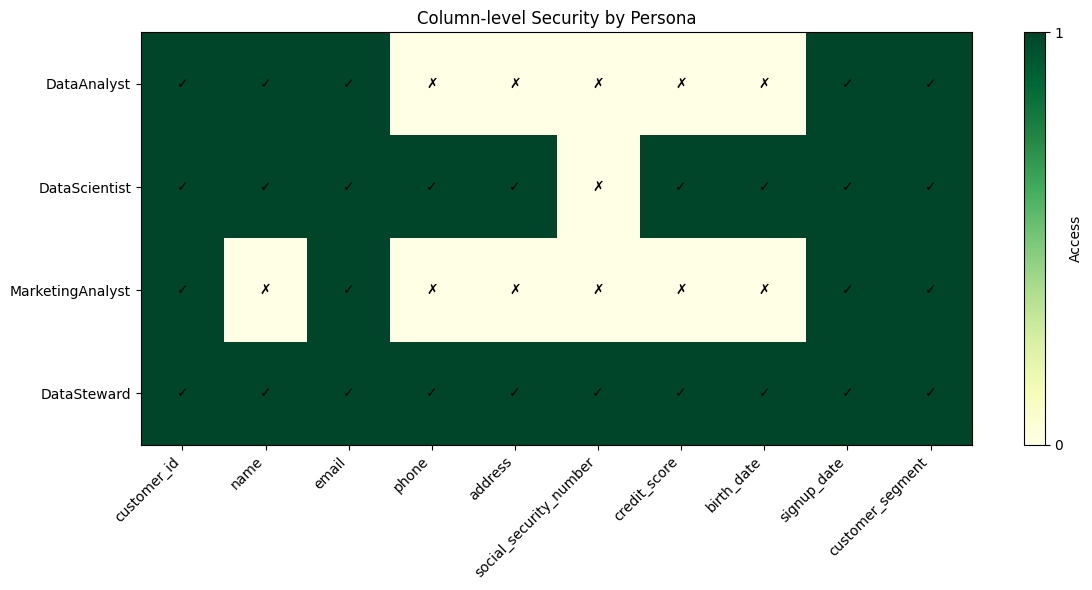

In [28]:
def visualize_column_permissions():
    """Create a visualization of column-level permissions"""
    
    # Define the columns each persona should be able to access
    personas = ['DataAnalyst', 'DataScientist', 'MarketingAnalyst', 'DataSteward']
    
    # Get customer_profiles table columns
    try:
        cp_table = glue.get_table(DatabaseName='customer_domain', Name='customer_profiles')
        columns = [col['Name'] for col in cp_table['Table']['StorageDescriptor']['Columns']]
        
        # Define which personas can access which columns
        access_matrix = [
            # DataAnalyst
            ['✓' if col in ['customer_id', 'name', 'email', 'customer_segment', 'signup_date'] else '✗' for col in columns],
            # DataScientist
            ['✓' if col != 'social_security_number' else '✗' for col in columns],
            # MarketingAnalyst
            ['✓' if col in ['customer_id', 'customer_segment', 'signup_date', 'email'] else '✗' for col in columns],
            # DataSteward
            ['✓' for _ in columns]
        ]
        
        # Create a pandas DataFrame for visualization
        df = pd.DataFrame(access_matrix, index=personas, columns=columns)
        
        # Display the matrix
        print("\nColumn-level permission matrix for customer_profiles table:")
        display(df)
        
        # Create a heatmap visualization
        plt.figure(figsize=(12, 6))
        # Convert ✓/✗ to 1/0 for heatmap
        heatmap_data = df.applymap(lambda x: 1 if x == '✓' else 0)
        plt.imshow(heatmap_data, cmap='YlGn', aspect='auto')
        plt.colorbar(ticks=[0, 1], label='Access')
        plt.xticks(range(len(columns)), columns, rotation=45, ha='right')
        plt.yticks(range(len(personas)), personas)
        plt.title('Column-level Security by Persona')
        
        # Add text annotations
        for i in range(len(personas)):
            for j in range(len(columns)):
                plt.text(j, i, df.iloc[i, j], ha='center', va='center', color='black')
                
        plt.tight_layout()
        plt.show()
        
    except ClientError as e:
        print(f"Error visualizing permissions: {e}")

visualize_column_permissions()

## Workshop Summary

Congratulations! You've successfully implemented enterprise-grade security for your data lake on AWS. Here's what you've accomplished:

1. **Created a secure data lake foundation**:
   - Set up an encrypted S3 bucket for the data lake
   - Registered the bucket with Lake Formation
   - Created domain-specific databases in the Glue Data Catalog

2. **Implemented column-level security**:
   - Created tables with different sensitivity levels
   - Applied column-level permissions based on personas
   - Restricted access to sensitive fields like social_security_number

3. **Established LF-Tags for scalable governance**:
   - Created tags for sensitivity levels and data domains
   - Applied tags to databases and columns
   - Granted permissions based on tag expressions

4. **Set up comprehensive audit and monitoring**:
   - Configured CloudTrail for API audit logging
   - Created CloudWatch metric filters to track sensitive data access
   - Built a monitoring dashboard for security oversight

### Next Steps

To further enhance your security implementation, consider:

1. **Implementing row-level security** using Lake Formation row filters to restrict access based on attributes like region or customer segment

2. **Setting up AWS Config rules** to continuously monitor for compliance with security best practices

3. **Implementing cross-account data sharing** using Lake Formation for secure collaboration with partners

4. **Creating self-service access request workflows** using AWS Service Catalog and Step Functions

5. **Implementing data masking** for sensitive fields to allow broader access while protecting privacy